In [2]:
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import plotly.offline as py
import matplotlib as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays
from sklearn.metrics import r2_score, mean_absolute_error

In [33]:
training_upto = 2020
forecast_upto = (2023-training_upto-1)*12 +3

## Prediction Whole of Barnet

In [34]:
# Read data, get dataframe with crimes/month
monthly_grouped_df = pd.read_csv('C:\\Users\\20203697\\Downloads\\filtered_df_utility_cols.csv')
monthly_grouped_df= monthly_grouped_df.sort_values(['Year','Month num'],ascending=False).groupby(['Year', 'Month num'])['Crime type'].count()
monthly_grouped_df = monthly_grouped_df.to_frame()


# Rename columns, select rows with data and set datetime index
monthly_grouped_df = monthly_grouped_df.rename(columns = {'Month num':'y'})
monthly_grouped_df['day'] = 1
monthly_grouped_df = monthly_grouped_df.reset_index()
# monthly_grouped_df = monthly_grouped_df[(monthly_grouped_df['Year']>=2011) | ((monthly_grouped_df['Year'] == 2010) & (monthly_grouped_df['Month num']==12))]
monthly_grouped_df = monthly_grouped_df.rename(columns={'Month num': 'month', 'Year': 'year'})
monthly_grouped_df['ds'] = pd.to_datetime(monthly_grouped_df[['year', 'month', 'day']])
monthly_grouped_df['y'] = monthly_grouped_df['Crime type']
# monthly_grouped_df = monthly_grouped_df.set_index(pd.DatetimeIndex(monthly_grouped_df['Date']))

# Getting Holidays
holiday = pd.DataFrame([])
for date, name in sorted(holidays.country_holidays('GB', subdiv='England', years=[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021, 2022, 2023, 2024]).items()):
    #holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0]), ignore_index=True)
    holiday= pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Divide test and train data
train_data = monthly_grouped_df[monthly_grouped_df['year']<(training_upto+1)]
test_data = monthly_grouped_df[(monthly_grouped_df['year']>training_upto)]

monthly_grouped_df


,year,month,Crime type,day,ds,y
0,2010,12,372,1,2010-12-01,372
1,2011,1,486,1,2011-01-01,486
2,2011,2,403,1,2011-02-01,403
3,2011,3,408,1,2011-03-01,408
4,2011,4,414,1,2011-04-01,414
...,...,...,...,...,...,...
143,2022,11,246,1,2022-11-01,246
144,2022,12,228,1,2022-12-01,228
145,2023,1,242,1,2023-01-01,242
146,2023,2,199,1,2023-02-01,199


### Hyper-parameter tuning

In [31]:
param_grid = { 
    'seasonality_mode':('multiplicative','additive'), 
    'changepoint_prior_scale': [0.05, 0.01, 0.15],
    'seasonality_prior_scale': [0.05, 0.01, 0.15],
    'holidays_prior_scale':[0.005,0.01,0.015],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the RMSEs for each params here

cutoffs = pd.date_range(start='2015-01-01', end='2021-12-01', freq='2MS')

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, holidays= holiday).fit(monthly_grouped_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
print("Mean absolute error: ", np.argmin(maes))
best_params = all_params[np.argmin(maes)]
print("Best parameters", best_params)

14:47:30 - cmdstanpy - INFO - Chain [1] start processing
14:47:30 - cmdstanpy - INFO - Chain [1] done processing


KeyboardInterrupt: 

14:47:54 - cmdstanpy - INFO - Chain [1] start processing
14:47:54 - cmdstanpy - INFO - Chain [1] done processing


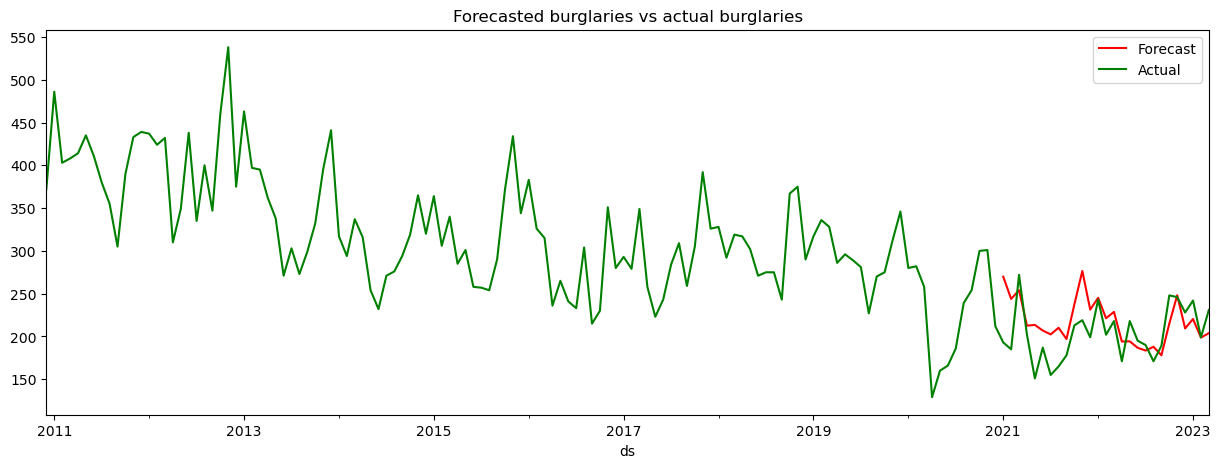

25.83032164474304


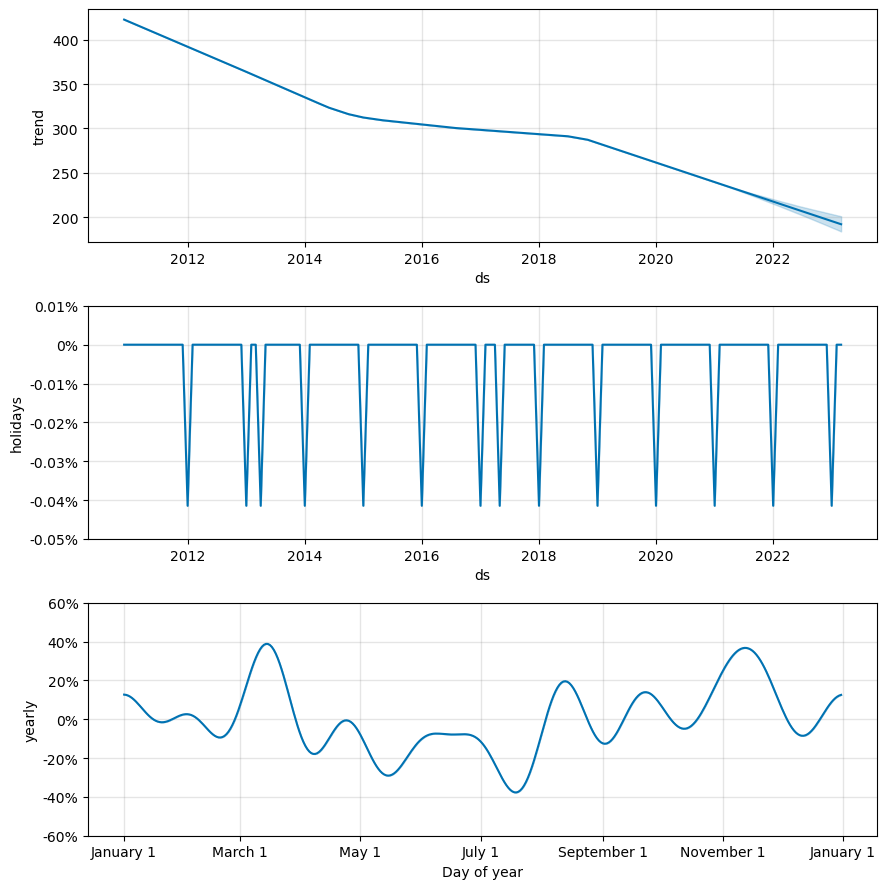

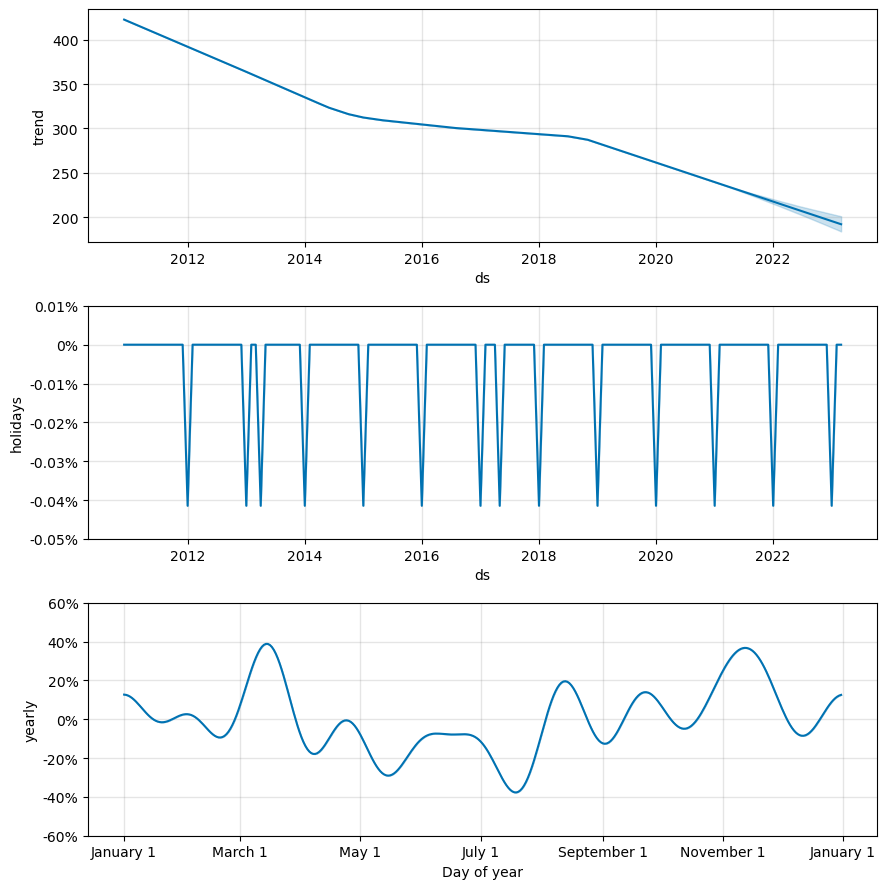

In [35]:
# Train the model with the best parameters and forecast

best_model = Prophet(seasonality_mode= 'multiplicative', changepoint_prior_scale= 0.15, seasonality_prior_scale= 0.15, holidays_prior_scale= 0.01, holidays= holiday).fit(train_data)
future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
forecast = best_model.predict(future_dates)

# Plot predictions
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
forecast[-forecast_upto:].plot(kind='line',x='ds', y='yhat', color='red', label='Forecast', ax=ax)
monthly_grouped_df.plot(kind='line',x='ds',y='y', color='green',label='Actual', ax=ax)
plt.title('Forecasted burglaries vs actual burglaries')
plt.show()

print(mean_absolute_error(test_data['y'], forecast['yhat'][-forecast_upto:]))
r2_score(test_data['y'], forecast['yhat'][-forecast_upto:])

best_model.plot_components(forecast)

## Prediction per ward

In [42]:
# Create the dataframe
file =  pd.read_csv('C:/Users/20203697/Downloads/filtered_df_utility_cols.csv')
df_per_ward= file.sort_values(['Year','Month num'],ascending=False).groupby(['Ward', 'Year', 'Month num', 'Population per square kilometre'])['Crime type'].count()
# Create a dataframe with the wanted dates
dates = pd.date_range(start='12/1/2010', end='3/1/2023', freq='MS').to_frame()
df_per_ward = df_per_ward.reset_index()
# Specify columns: ds, y, Date
df_per_ward['day'] = 1
df_per_ward = df_per_ward.reset_index()
df_per_ward['y'] = df_per_ward['Crime type']
df_per_ward = df_per_ward.rename(columns={'Month num': 'month', 'Year': 'year'})
df_per_ward['ds'] = pd.to_datetime(df_per_ward[['year', 'month', 'day']])
df_per_ward['Date'] = df_per_ward['ds']
dates['Date'] = dates[0]
dates = dates[['Date']]
print(df_per_ward.columns)

Index(['index', 'Ward', 'year', 'month', 'Population per square kilometre',
       'Crime type', 'day', 'y', 'ds', 'Date'],
      dtype='object')


df ward Index(['ds', 'Date', 'year', 'y', 'Population per square kilometre'], dtype='object')
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


C:\Users\20203697\AppData\Local\Temp\ipykernel_23692\2586375284.py:37: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

15:00:00 - cmdstanpy - INFO - Chain [1] start processing
15:00:00 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
Brunswick Park
-0.09556362837204002


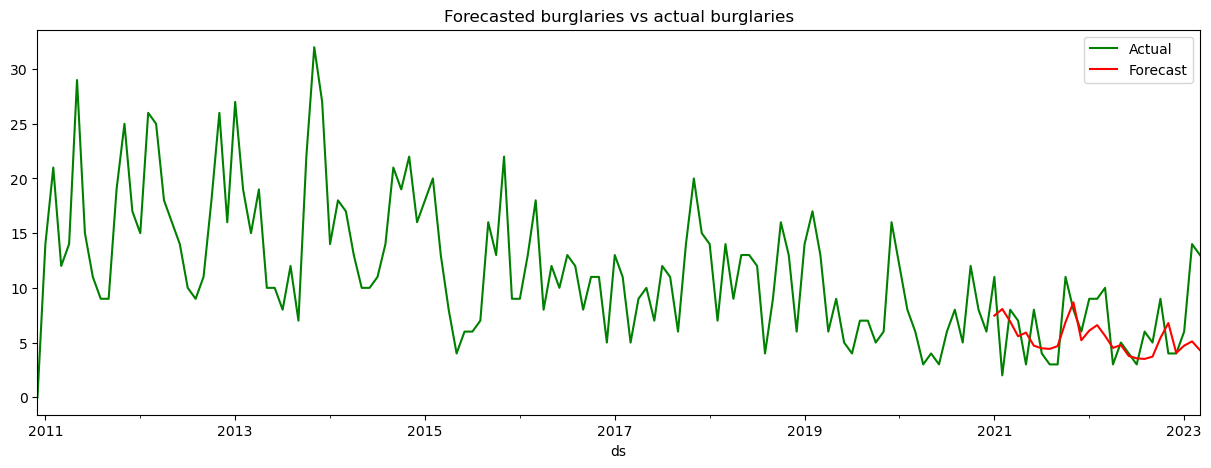

df ward Index(['ds', 'Date', 'year', 'y', 'Population per square kilometre'], dtype='object')
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


C:\Users\20203697\AppData\Local\Temp\ipykernel_23692\2586375284.py:37: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

15:00:01 - cmdstanpy - INFO - Chain [1] start processing
15:00:01 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
Burnt Oak
-0.7810310410270147


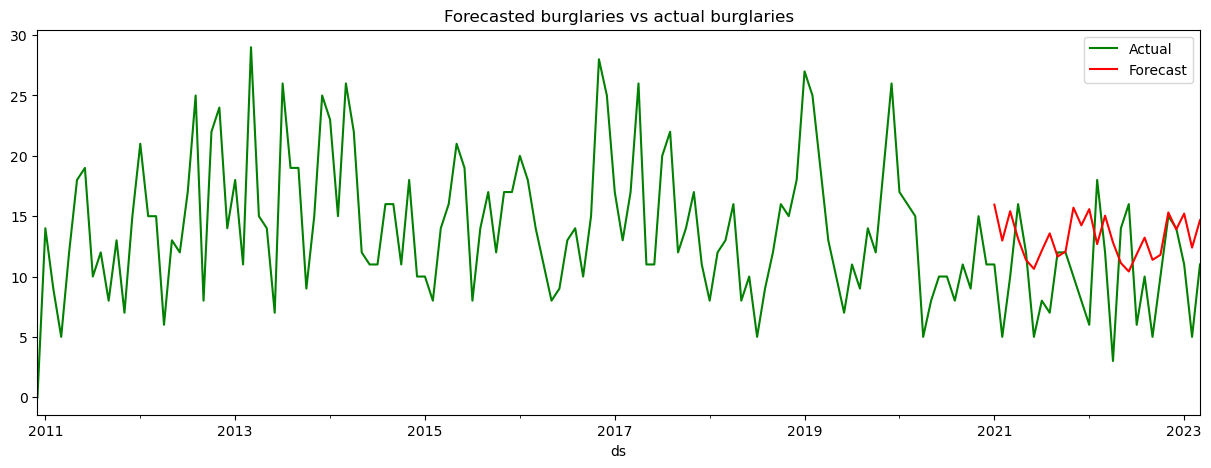

df ward Index(['ds', 'Date', 'year', 'y', 'Population per square kilometre'], dtype='object')
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


C:\Users\20203697\AppData\Local\Temp\ipykernel_23692\2586375284.py:37: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

15:00:02 - cmdstanpy - INFO - Chain [1] start processing
15:00:03 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
Childs Hill
-0.13184089662252574


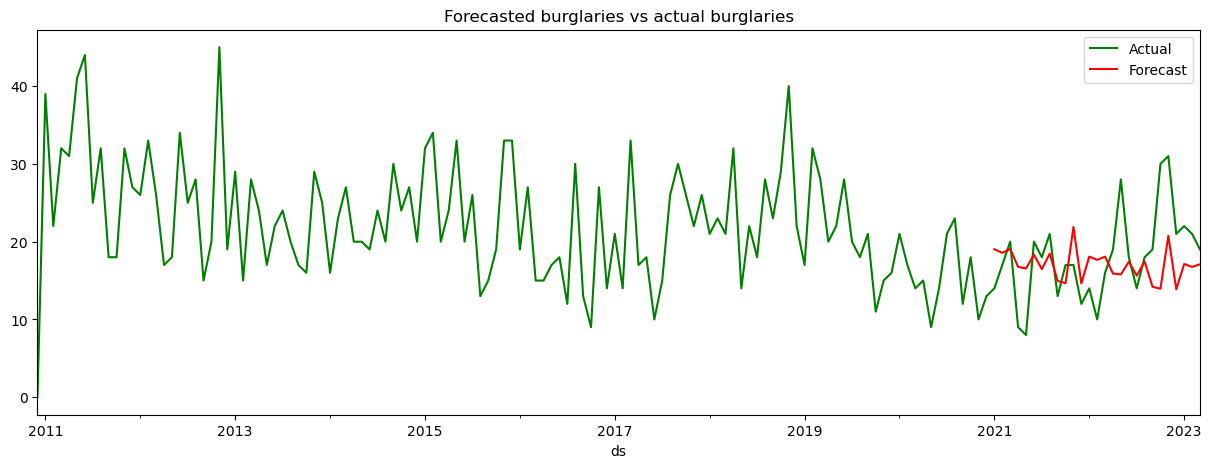

df ward Index(['ds', 'Date', 'year', 'y', 'Population per square kilometre'], dtype='object')
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


C:\Users\20203697\AppData\Local\Temp\ipykernel_23692\2586375284.py:37: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

15:00:05 - cmdstanpy - INFO - Chain [1] start processing
15:00:05 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
East Barnet
0.06489497088158092


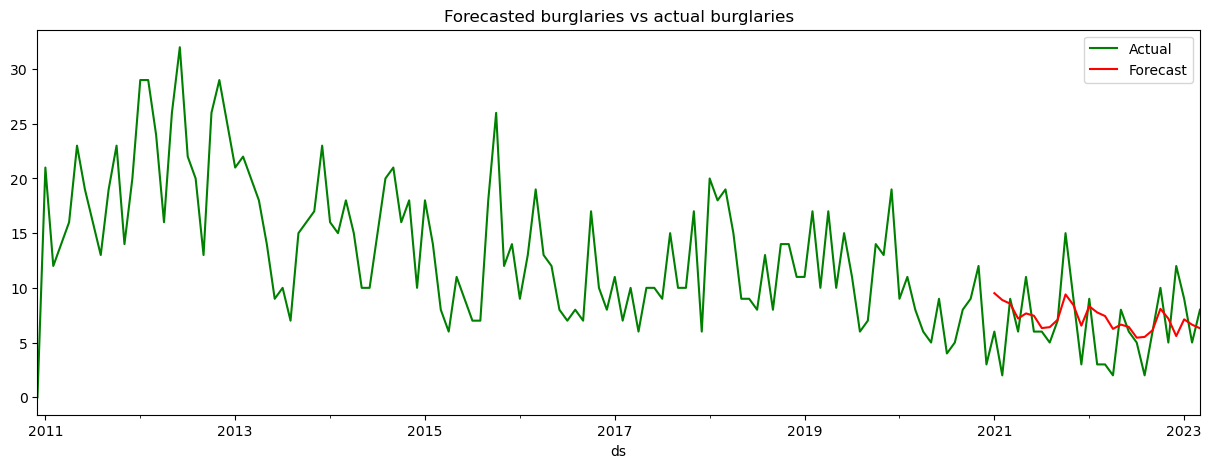

df ward Index(['ds', 'Date', 'year', 'y', 'Population per square kilometre'], dtype='object')
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


C:\Users\20203697\AppData\Local\Temp\ipykernel_23692\2586375284.py:37: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

15:00:07 - cmdstanpy - INFO - Chain [1] start processing
15:00:07 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
East Finchley
-0.21893307990137512


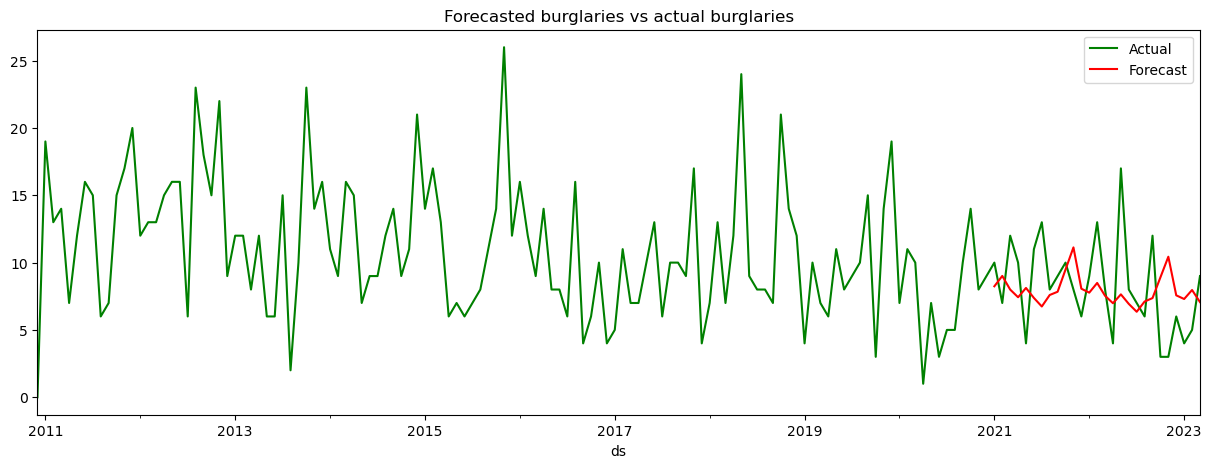

df ward Index(['ds', 'Date', 'year', 'y', 'Population per square kilometre'], dtype='object')
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


C:\Users\20203697\AppData\Local\Temp\ipykernel_23692\2586375284.py:37: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

15:00:09 - cmdstanpy - INFO - Chain [1] start processing
15:00:09 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
Edgware
-0.49296593484599893


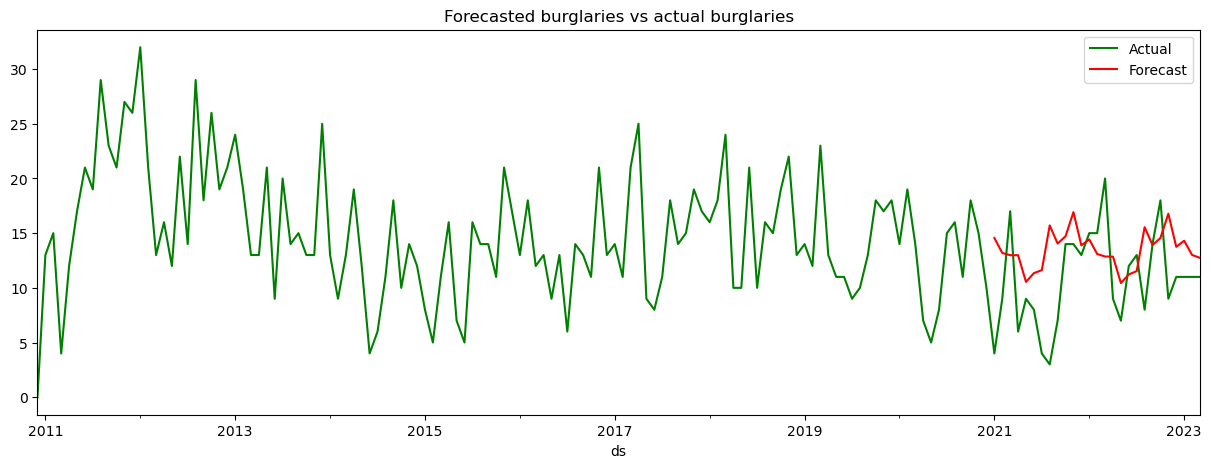

df ward Index(['ds', 'Date', 'year', 'y', 'Population per square kilometre'], dtype='object')
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


C:\Users\20203697\AppData\Local\Temp\ipykernel_23692\2586375284.py:37: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

15:00:10 - cmdstanpy - INFO - Chain [1] start processing
15:00:10 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
Finchley Church End
0.07189776685454496


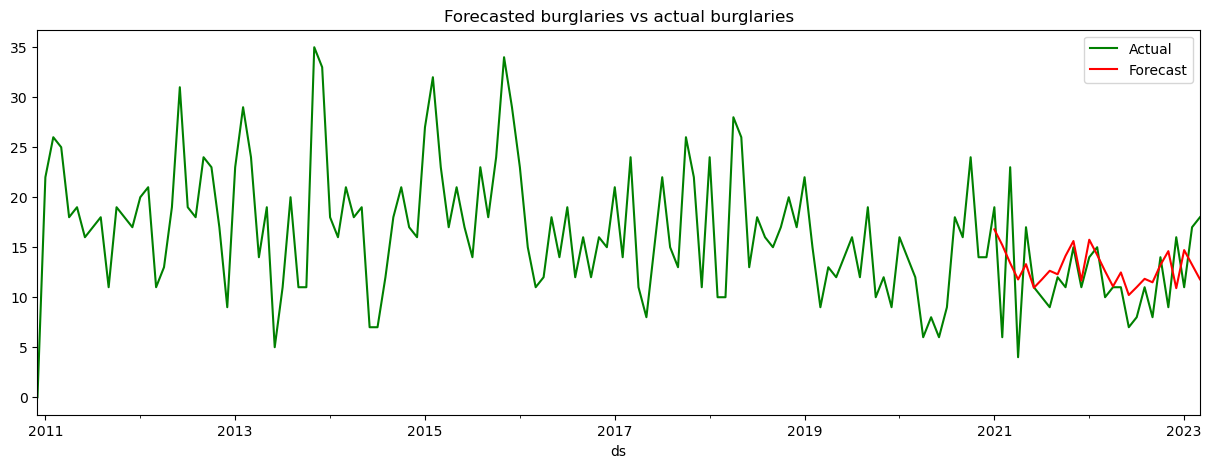

df ward Index(['ds', 'Date', 'year', 'y', 'Population per square kilometre'], dtype='object')
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


C:\Users\20203697\AppData\Local\Temp\ipykernel_23692\2586375284.py:37: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

15:00:11 - cmdstanpy - INFO - Chain [1] start processing
15:00:11 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
Garden Suburb
-1.5958981861183097


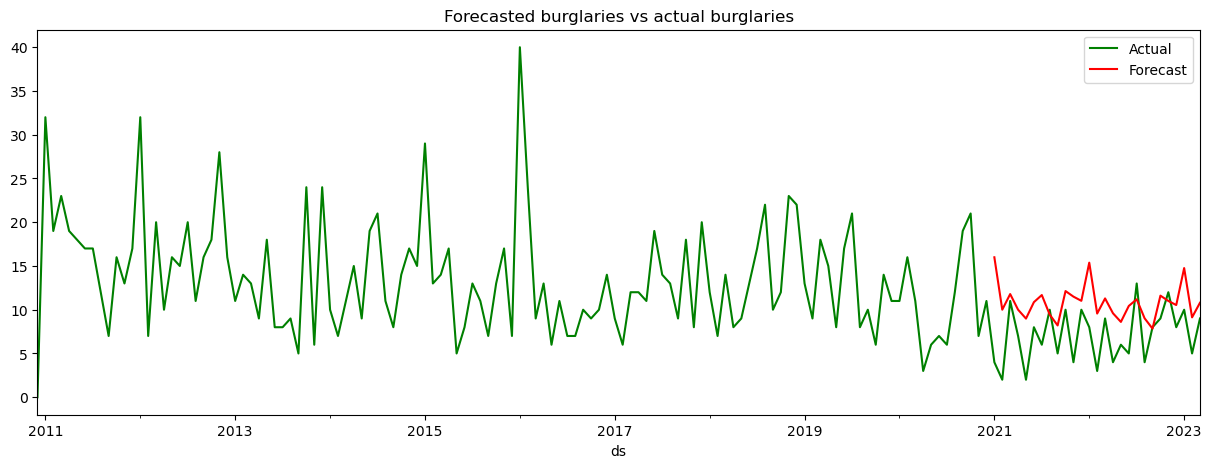

df ward Index(['ds', 'Date', 'year', 'y', 'Population per square kilometre'], dtype='object')
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


C:\Users\20203697\AppData\Local\Temp\ipykernel_23692\2586375284.py:37: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

15:00:13 - cmdstanpy - INFO - Chain [1] start processing
15:00:13 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
Golders Green
-0.5860828186176186


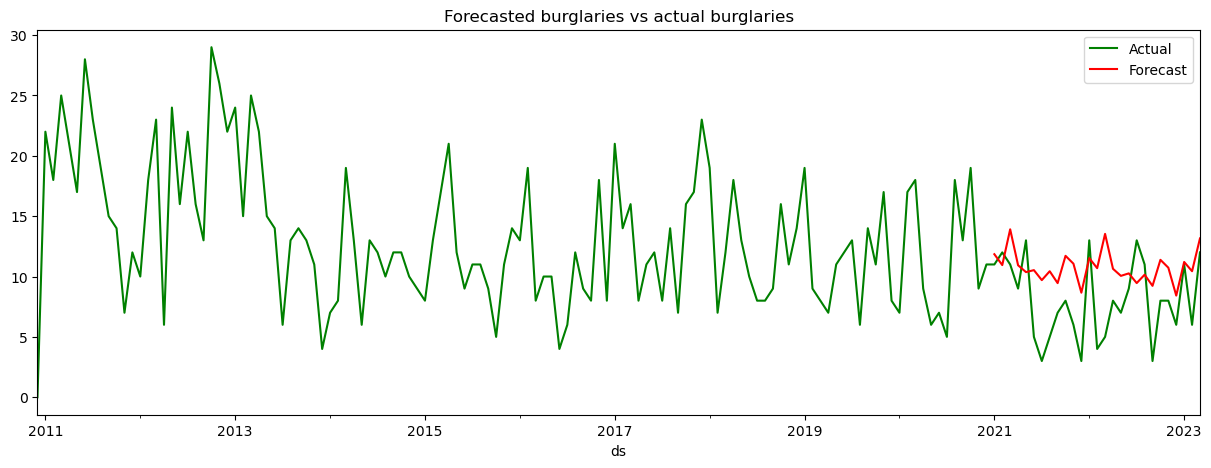

df ward Index(['ds', 'Date', 'year', 'y', 'Population per square kilometre'], dtype='object')
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


C:\Users\20203697\AppData\Local\Temp\ipykernel_23692\2586375284.py:37: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

15:00:14 - cmdstanpy - INFO - Chain [1] start processing
15:00:14 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
Hendon
0.0036357898412890943


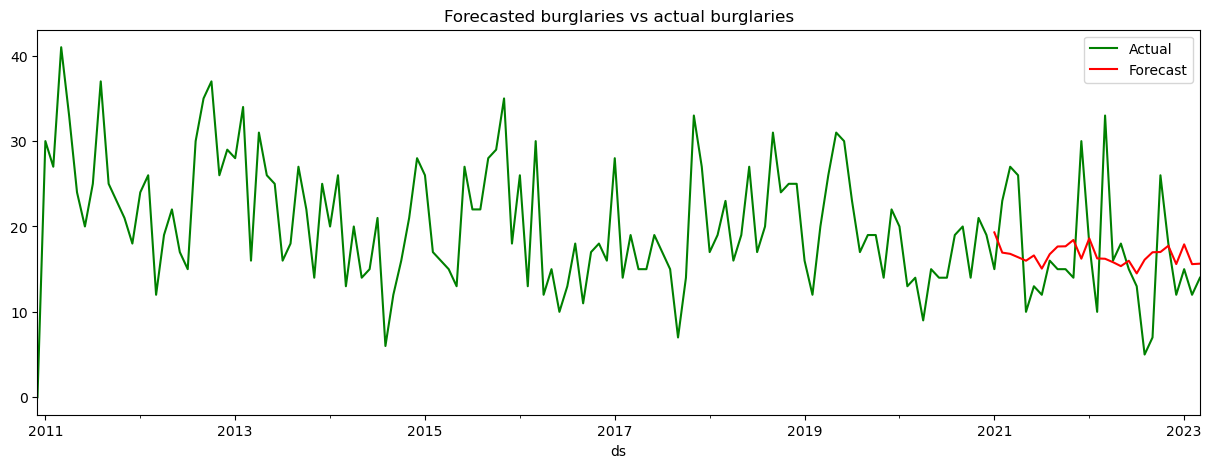

df ward Index(['ds', 'Date', 'year', 'y', 'Population per square kilometre'], dtype='object')
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


C:\Users\20203697\AppData\Local\Temp\ipykernel_23692\2586375284.py:37: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

15:00:15 - cmdstanpy - INFO - Chain [1] start processing
15:00:16 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
High Barnet
-0.3286739080435357


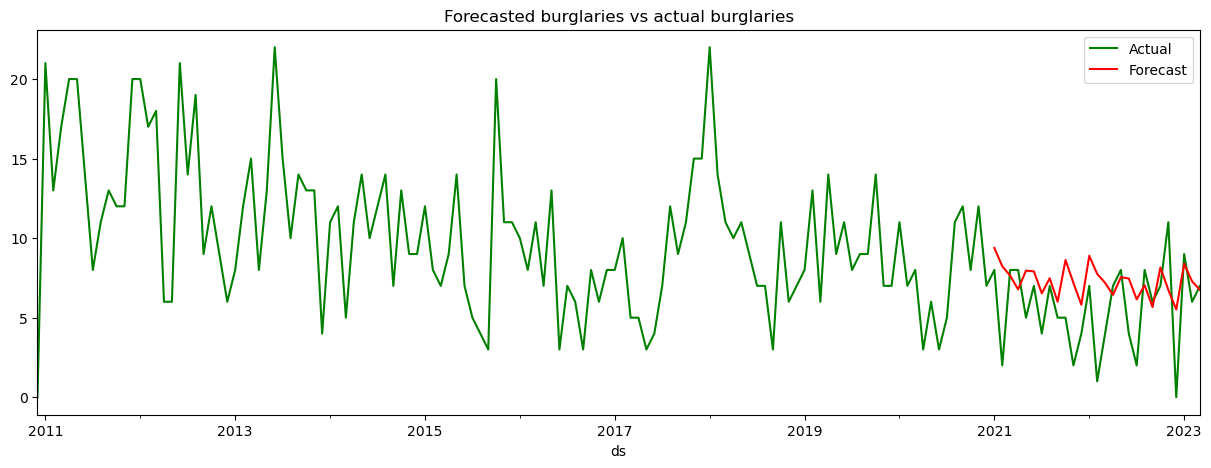

df ward Index(['ds', 'Date', 'year', 'y', 'Population per square kilometre'], dtype='object')
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


C:\Users\20203697\AppData\Local\Temp\ipykernel_23692\2586375284.py:37: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

15:00:17 - cmdstanpy - INFO - Chain [1] start processing
15:00:17 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
Mill Hill
-0.20576209704127812


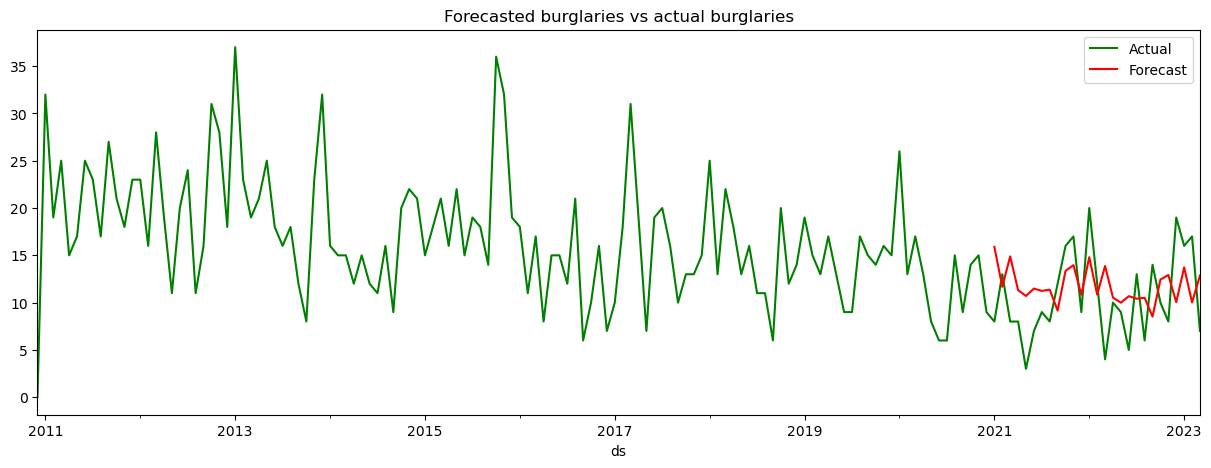

df ward Index(['ds', 'Date', 'year', 'y', 'Population per square kilometre'], dtype='object')
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


C:\Users\20203697\AppData\Local\Temp\ipykernel_23692\2586375284.py:37: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

15:00:19 - cmdstanpy - INFO - Chain [1] start processing
15:00:19 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
Underhill
-5.105802413029577


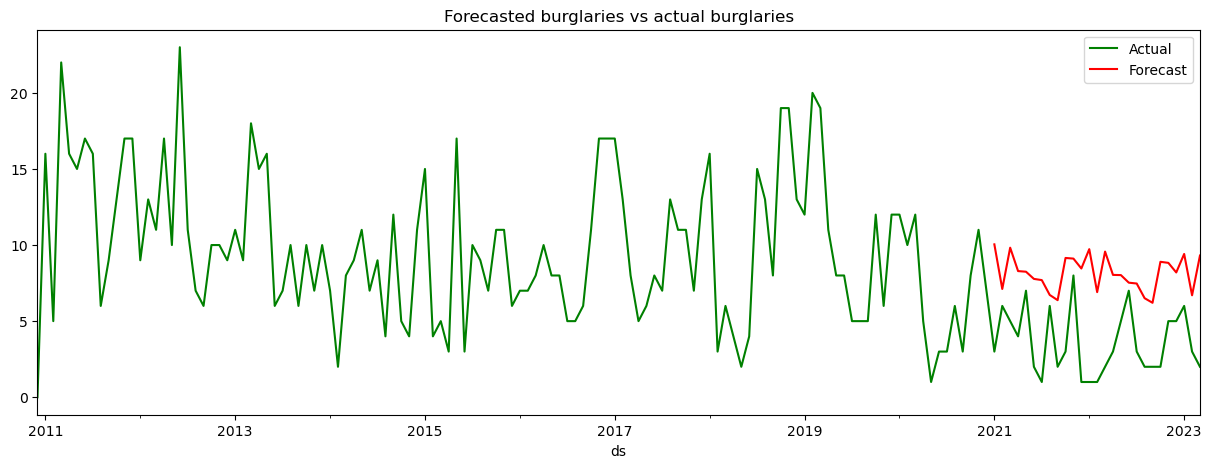

df ward Index(['ds', 'Date', 'year', 'y', 'Population per square kilometre'], dtype='object')
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


C:\Users\20203697\AppData\Local\Temp\ipykernel_23692\2586375284.py:37: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

15:00:20 - cmdstanpy - INFO - Chain [1] start processing
15:00:20 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
West Finchley
0.32610034755612205


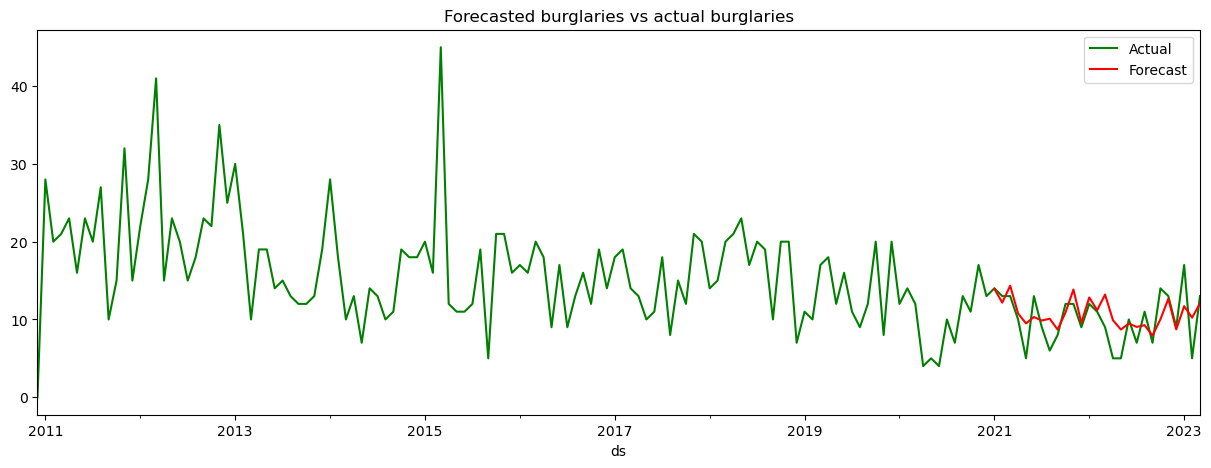

df ward Index(['ds', 'Date', 'year', 'y', 'Population per square kilometre'], dtype='object')
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


C:\Users\20203697\AppData\Local\Temp\ipykernel_23692\2586375284.py:37: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

15:00:21 - cmdstanpy - INFO - Chain [1] start processing
15:00:21 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
West Hendon
-0.9967681114960927


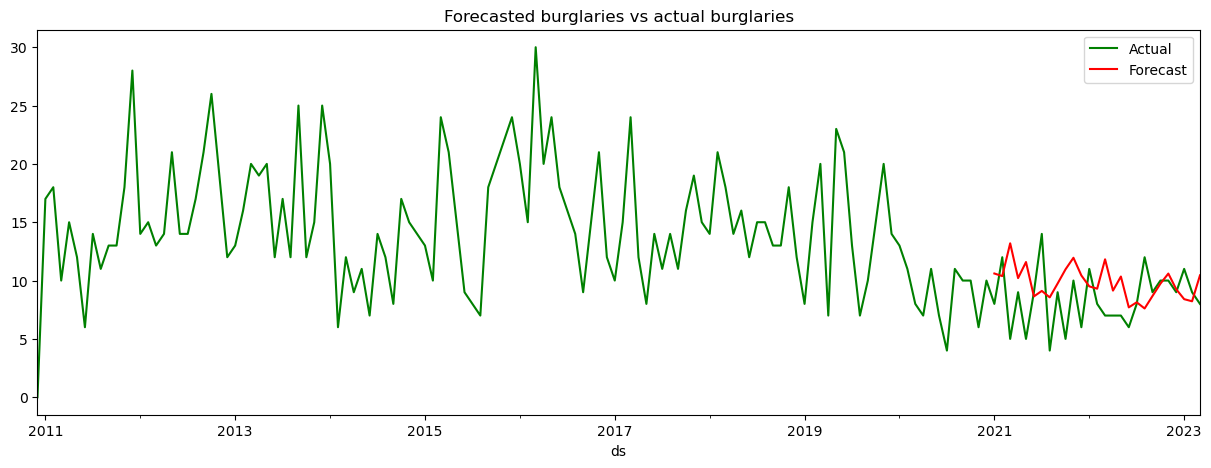

df ward Index(['ds', 'Date', 'year', 'y', 'Population per square kilometre'], dtype='object')
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


C:\Users\20203697\AppData\Local\Temp\ipykernel_23692\2586375284.py:37: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

15:00:22 - cmdstanpy - INFO - Chain [1] start processing
15:00:23 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
143 2022-11-01
144 2022-12-01
145 2023-01-01
146 2023-02-01
147 2023-03-01

[148 rows x 1 columns]
Woodhouse
-0.19199803850626318


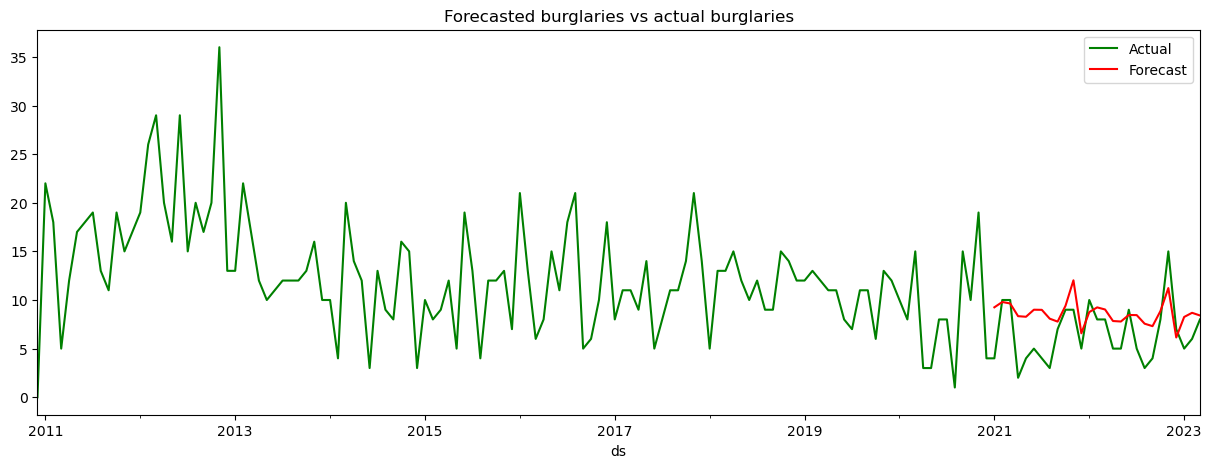

In [43]:
#print(df_per_ward)

# Get holiday dataset
holiday = pd.DataFrame([])
for date, name in sorted(holidays.country_holidays('GB', subdiv='England', years=[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021, 2022, 2023]).items()):
    holiday= pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Create a dataframe with the wanted dates
dates = pd.date_range(start='12/1/2010', end='3/1/2023', freq='MS').to_frame()

# Specify columns: ds, y, Date
df_per_ward['day'] = 1
df_per_ward = df_per_ward.reset_index()
df_per_ward = df_per_ward.rename(columns={'Month num': 'month', 'Year': 'year'})
df_per_ward['ds'] = pd.to_datetime(df_per_ward[['year', 'month', 'day']])
df_per_ward['Date'] = df_per_ward['ds']
dates['Date'] = dates[0]
dates = dates[['Date']]

# Loop over wards
wards = ['Brunswick Park', 'Burnt Oak', 'Childs Hill', 'East Barnet',
       'East Finchley', 'Edgware', 'Finchley Church End', 'Garden Suburb',
       'Golders Green', 'Hendon', 'High Barnet', 'Mill Hill', 'Underhill',
       'West Finchley', 'West Hendon', 'Woodhouse']

for ward in wards: 
       # Select data of ward
       df_ward = df_per_ward[df_per_ward['Ward']==ward]
       df_ward = df_ward[['ds', 'Date', 'year', 'y', 'Population per square kilometre']]
       print('df ward', df_ward.columns)
       # Merge with all dates to have a consistent dataframe
       df_ward = pd.merge(dates, df_ward, how="left", on='Date')
       df_ward['ds'] = df_ward['Date']
       df_ward['y'] = df_ward['y'].fillna(0)
       df_ward = df_ward.fillna(df_ward.mean())
       df_ward['year'] = pd.DatetimeIndex(df_ward['Date']).year
       train_ward = df_ward[df_ward['year']<(training_upto+1)]
       test_ward = df_ward[(df_ward['year']>training_upto)] 
       print(df_ward.columns)
       best_model = Prophet(seasonality_mode= 'multiplicative', changepoint_prior_scale= 0.15, seasonality_prior_scale= 0.15, holidays_prior_scale= 0.01, holidays= holiday)
       best_model.add_regressor('Population per square kilometre')
       best_model.fit(train_ward)
       future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
       print(future_dates)
       future_dates = pd.merge(future_dates, df_ward, how="left", on='ds')
       forecast = best_model.predict(future_dates)
       print(ward)
       print(r2_score(test_ward[['y']], forecast['yhat'][-forecast_upto:]))
       f, ax = plt.subplots(figsize=(14,5))
       f.set_figheight(5)
       f.set_figwidth(15)
       
       df_ward.plot(kind='line',x='ds',y='y', color='green',label='Actual', ax=ax)
       forecast[-forecast_upto:].plot(kind='line',x='ds', y='yhat', color='red', label='Forecast', ax=ax)
       plt.title('Forecasted burglaries vs actual burglaries')
       plt.show()
       